In this notebook, I will use torch_geometric to predict the developpement of a graph of positions through time

In [1]:
"""
I realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635
"""

'\nI realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635\n'

In [2]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import pickle

import sys
import os
from genericpath import exists

from cell_dataset import CellGraphDataset, load, single_overfit_dataset
from cell_model import GraphEvolution, GraphEvolutionDiscr
from cell_utils import GraphingLoss
from cell_training import train, test_single, compute_parameters, run_single, run_single_recursive

import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
try :
    import allium
except :
    print("Could not import allium")

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using :  290
Available :  3270
True
Could not import allium


The data is a graph of cells having their own positions and velocity.

In the graph, we will first start by connecting all the edges, then maybe later make radius_graphs to reduce the cost of the pass through the model

In [3]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_hv"

model_path = "models/model" + extension + "_"
loss_path = "models/loss" + extension + "_"

data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

Validation data not found


In [4]:
data_train, data_test = single_overfit_dataset(data_train, data_test)

In [5]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, batch_edge, border, params = data_train.get(0)
rval, edge_index, edge_attr, batch_edge, border, params = data_test.get(0)

print("Is data wrapped ? ", data_train.wrap)

Is data wrapped ?  False


Next we need to define the model that will be used :
    > input 
        (1) Graph at a particular time t (nodes having x,y,dx,dy as attributes)
        (2) Graphs up to a particular time [t-a, t] (nodes having x,y as attributes)
    > output
        (a) Graph at the immediate next time step t+1
        (b) Graph [t, t+b]
        (c) Graph at t+b
    > graph size
        (x) Fixed graph size to the most nodes possible (or above)
        (y) Unbounded graph size
            >> idea : graph walks
            >> idea : sampler

The following model will do (1ax)

In [6]:
def start(model : GraphEvolution, optimizer : torch.optim.Optimizer, scheduler  : torch.optim.lr_scheduler._LRScheduler,\
          data_train : CellGraphDataset, data_test : CellGraphDataset, device : torch.device, epoch : int, offset : int, grapher : GraphingLoss, save=0, save_datasets=True):
    
    loss_history_train = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    loss_history_test_recursive = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    loss_history_test_single = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    for e in range(offset, offset + epoch):
        
        recursive = True

        for i in range(100) :
            train(model, optimizer, scheduler, data_train, device, e, process, max_epoch=offset+epoch, loss_history = loss_history_train, recursive=recursive)

        #model.show_gradients()
        
        if(e == 0 and save_datasets) :
            data_train.thread = None
            data_test.thread = None
            with open("data/training" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_train, f)
            with open("data/testing" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_test, f)
            print("Saved datasets")
        

        test_loss_s = test_single(model, data_test, device, loss_history_test_recursive, duration=16, recursive=False)
        test_loss_r = test_single(model, data_test, device, loss_history_test_single, duration=16, recursive=True)

        print("Epoch : ", e, "Test loss : ", test_loss_s, "Test loss recursive : ", test_loss_r)


        grapher.plot_losses(title="Training", data=loss_history_train, extension=extension)
        grapher.plot_losses(title="Testing", data=loss_history_test_recursive, extension=extension)
        grapher.plot_losses(title="Testing recursive", data=loss_history_test_single, extension=extension)
        
        if (e%save == 0) :      
            all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1)
            grapher.plot_params(all_params_out, all_params_true, e, extension=extension)
        
        if (save and (e%save == 0 or e == epoch-1)) :
            torch.save(model.state_dict(), model_path + str(e) + ".pt")

In [7]:
load = True

epoch_to_load = 2000

model = GraphEvolution(in_channels=14, out_channels=4, hidden_channels=64, dropout=0.05, edge_dim=2, messages=8, wrap=data_train.wrap)
#model = GraphEvolution(in_channels=9, out_channels=4, hidden_channels=32, dropout=0.01, edge_dim=2, messages=5, wrap=True)
#model = GraphEvolutionDiscr(in_channels=9, out_channels=4, hidden_channels=16, dropout=0.01, edge_dim=2, messages=5, wrap=True)

if exists(model_path + str(epoch_to_load) + ".pt") and load :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

Loaded model


In [8]:
#might want to investigate AdamP 
optimizer = AdamP(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-0, weight_decay=5e-3, delta=0.1, wd_ratio=0.1, nesterov=True)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2, eta_min=1e-10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
epochs = 8000
grapher = GraphingLoss()

model = model.to(device)
data_train.to(device)
data_test.to(device)


#all_params_out, all_params_true = compute_parameters(model.to(device), data_test, device, duration=0)
#grapher.plot_params(all_params_out, all_params_true, epoch_to_load, extension=extension)

c:\Users\gille\Desktop\graph-displacement\cell_dataset.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  border = torch.tensor(border)


In [10]:
start(model, optimizer, scheduler, data_train, data_test, device, \
        epochs, epoch_to_load, grapher=grapher, save=100, save_datasets=False)

Epoch :  2000 Test loss :  -3.6010844707489014 Test loss recursive :  0.48980283737182617
Epoch :  2001 Test loss :  -3.2969605922698975 Test loss recursive :  1.1564370393753052
Epoch :  2002 Test loss :  -3.6886045932769775 Test loss recursive :  1.0741231441497803
Epoch :  2003 Test loss :  -3.462993621826172 Test loss recursive :  2.846494436264038
Epoch :  2004 Test loss :  -3.44260311126709 Test loss recursive :  6.674125671386719
Epoch :  2005 Test loss :  -3.641794443130493 Test loss recursive :  2.434662103652954
Epoch :  2006 Test loss :  -3.7089388370513916 Test loss recursive :  1.2757904529571533
Epoch :  2007 Test loss :  -3.6529815196990967 Test loss recursive :  2.461158514022827
Epoch :  2008 Test loss :  -3.5138039588928223 Test loss recursive :  0.5894111394882202
Epoch :  2009 Test loss :  -3.744088888168335 Test loss recursive :  1.3648607730865479
Epoch :  2010 Test loss :  -3.709723472595215 Test loss recursive :  1.7366132736206055
Epoch :  2011 Test loss :  -3.

KeyboardInterrupt: 

In [ ]:
all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1)
grapher.plot_params(all_params_out, all_params_true, epochs - 1, extension=extension)


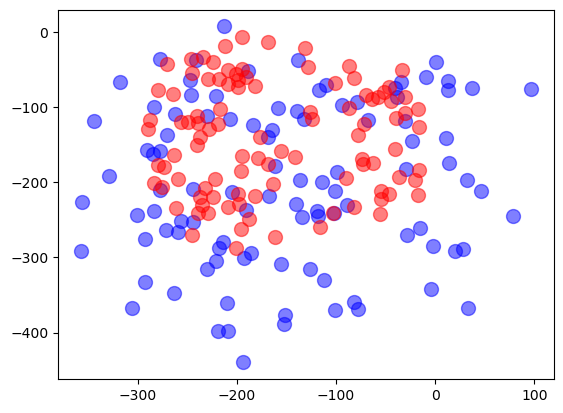

In [ ]:
loss_history = {'loss_mean' : [], 'loss_log' : [], 'loss' : []}
loss, out, x = run_single_recursive(model, data_test, 0, device, loss_history, output=True)

if out == None or x == None :
    raise Exception("No output")

with open("models/result_recursive_" + str(epochs-1) + ".pkl", "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.show()
plt.close()


In [ ]:
from cell_utils import  make_animation
from cell_utils import singleCellTrajectoryAnimation
from genericpath import exists

possible_extensions = [extension]
possible_epochs = [999]

for ext in possible_extensions :
    for epo in possible_epochs :
        if exists("models/result_recursive_" + str(epo) + ".pkl") :
            result_name = "models/result_recursive_" + str(epo) + ".pkl"
            animation_name = "models/animation_recursive_" + str(epo) + ".mp4"
            make_animation(result_name, animation_name, show_speed=False)
            
            animation_name = "models/animation_recursive_traj_" + str(epo) + ".mp4"
            singleCellTrajectoryAnimation(result_name, animation_name, show_speed=False)